## Кредитный скоринг на клиентах, уже бравших кредиты

Описания полей датасета
- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import cross_validate

import os

# этот блок используется только локальном компьютере
from importlib import reload
print(os.listdir('./data'))
PATH_to_file = './data/'

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
import helper_v31102020 as utils

In [3]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('25/10/2020')

## 1. Загрузка данных и предварительный анализ

In [4]:
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [5]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
display(df.sample(5))
print('Размерность объединенного датасета: ', df.shape)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
72356,103178,21APR2014,SCH,M,25,N,N,0,0,-2.538379,2,50,1,2,12000,1,3,N,0.0,1
60734,73229,20MAR2014,GRD,F,28,N,N,2,0,-1.671180,3,80,2,3,30000,1,3,Y,0.0,1
44961,45821,22FEB2014,SCH,F,28,N,N,0,0,-1.710720,2,60,2,3,17000,2,4,N,0.0,1
61284,79703,27MAR2014,GRD,F,31,Y,Y,0,0,-2.046855,1,80,2,3,5000,1,3,N,0.0,1
100947,78297,26MAR2014,GRD,M,37,Y,Y,0,0,-2.758620,2,60,1,2,50000,1,4,N,NaN,0


Размерность объединенного датасета:  (110148, 20)


In [6]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'Train'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

**Резюме по предварительному анализу:**
Тренировочный датасет: 73799 записей, Тестовый датасет: 36349, всего: 110148 записей.
19 признаков, из них client_id - идентификатор, Train - признак тренировочного датасета, 1 целевая переменная default.
Признак edication содержит пропуски: 478

## 2. Анализ переменных

1. Целевая переменная **default**

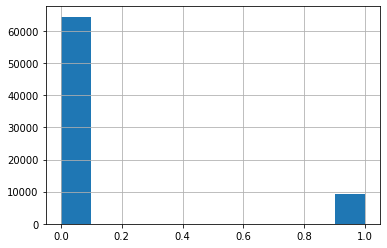

In [8]:
df.default.hist()

### Числовые (непрерывные) переменные

2. **age**

Количество: 110148, Среднее: 39.249, Стандартное отклонение: 11.518.
Минимум: 21, 25-й перцентиль: 30.0, Медиана: 37.0, 75-й перцентиль: 48.0, Максимум: 72, IQR: 18.0.
Количество пропусков в столбце:  0
Границы выбросов: [3.0, 75.0]. Количество выбросов:  0


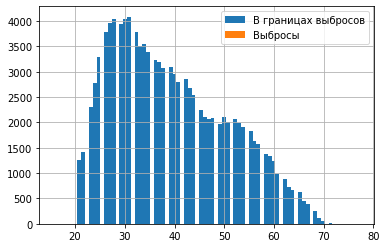

In [9]:
utils.analyse_numeric(df, 'age', 80)

3. **decline_app_cnt**

Количество: 110148, Среднее: 0.273, Стандартное отклонение: 0.799.
Минимум: 0, 25-й перцентиль: 0.0, Медиана: 0.0, 75-й перцентиль: 0.0, Максимум: 33, IQR: 0.0.
Количество пропусков в столбце:  0
Границы выбросов: [0.0, 0.0]. Количество выбросов:  18677


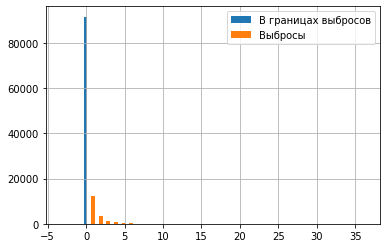

In [10]:
utils.analyse_numeric(df, 'decline_app_cnt', 80)

4. **bki_request_cnt**

Количество: 110148, Среднее: 2.005, Стандартное отклонение: 2.267.
Минимум: 0, 25-й перцентиль: 0.0, Медиана: 1.0, 75-й перцентиль: 3.0, Максимум: 53, IQR: 3.0.
Количество пропусков в столбце:  0
Границы выбросов: [-4.5, 7.5]. Количество выбросов:  2636


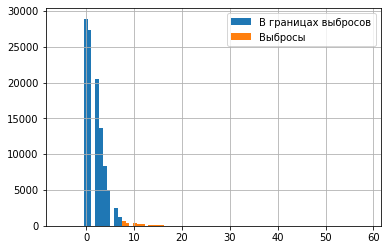

In [11]:
utils.analyse_numeric(df, 'bki_request_cnt', 80)

5. **income**

Количество: 110148, Среднее: 41012.649, Стандартное отклонение: 45399.735.
Минимум: 1000, 25-й перцентиль: 20000.0, Медиана: 30000.0, 75-й перцентиль: 48000.0, Максимум: 1000000, IQR: 28000.0.
Количество пропусков в столбце:  0
Границы выбросов: [-22000.0, 90000.0]. Количество выбросов:  7000


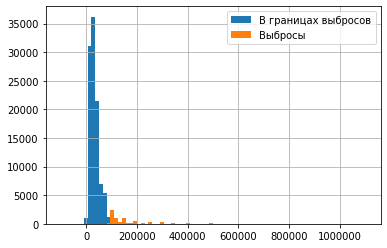

In [12]:
utils.analyse_numeric(df, 'income', 80)

6. **score_bki**

Количество: 110148, Среднее: -1.905, Стандартное отклонение: 0.499.
Минимум: -3.62458632, 25-й перцентиль: -2.2604336700000003, Медиана: -1.92082293, 75-й перцентиль: -1.5678881525, Максимум: 0.19977285, IQR: 0.6925455175000004.
Количество пропусков в столбце:  0
Границы выбросов: [-3.299251946250001, -0.5290698762499992]. Количество выбросов:  518


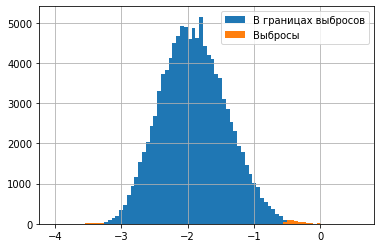

In [13]:
utils.analyse_numeric(df, 'score_bki', 80)

7. Временной ряд **app_date**

In [14]:
# Преобразуем в DateTime
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [15]:
# Границы периода
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

Период: с 1 января по 30 апреля 2014 года

In [16]:
# Вводим новый признак - количество дней 1 января
df['days'] = (df.app_date - start).dt.days.astype('int')

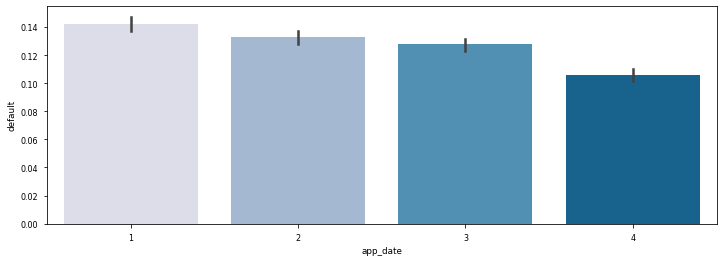

In [17]:
# Среднее число дефолтов уменьшается с увеличением месяца подачи заявки
plt.style.use('seaborn-paper')
plt.subplots(figsize=(12, 4))
color_text = plt.get_cmap('PuBu')(0.85)
sns.barplot(data=df[df['Train']==1], x=df.loc[df['Train']==1,'app_date'].dt.month, y='default', palette="PuBu");

Прологарифмируем некоторые непрерывные переменные и сгенерируем новые признаки

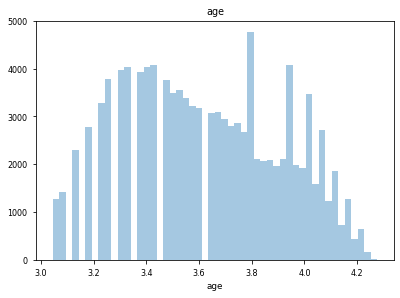

In [18]:
plt.figure()
sns.distplot(np.log(df['age']), kde = False, rug=False)
plt.title('age')
plt.show()

In [19]:
df['age'] = np.log(df['age'])

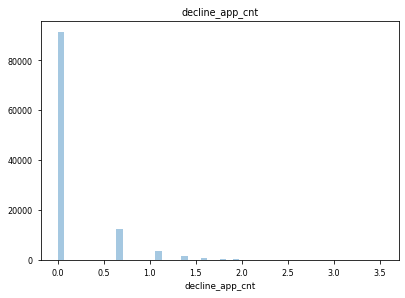

In [20]:
plt.figure()
sns.distplot(np.log(df['decline_app_cnt'] + 1) , kde = False, rug=False)
plt.title('decline_app_cnt')
plt.show()

In [21]:
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)

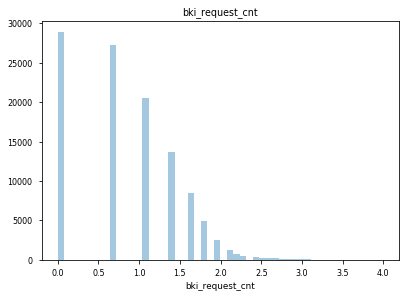

In [22]:
plt.figure()
sns.distplot(np.log(df['bki_request_cnt'] + 1), kde = False, rug=False)
plt.title('bki_request_cnt')
plt.show()

In [23]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

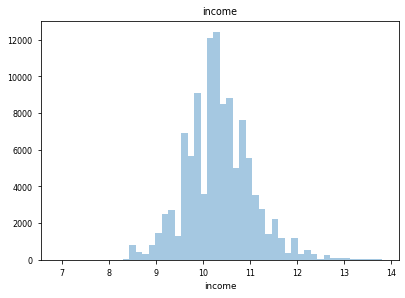

In [24]:
plt.figure()
sns.distplot(np.log(df['income']), kde = False, rug=False)
plt.title('income')
plt.show()

In [25]:
df['income'] = np.log(df['income'])

In [26]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'days']

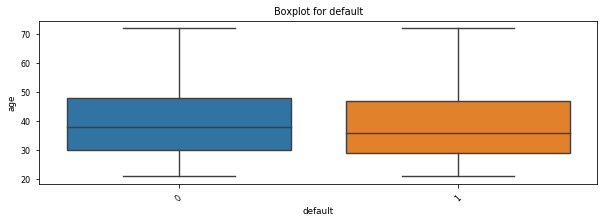

In [27]:
utils.get_boxplot(df_train, 'default', 'age')

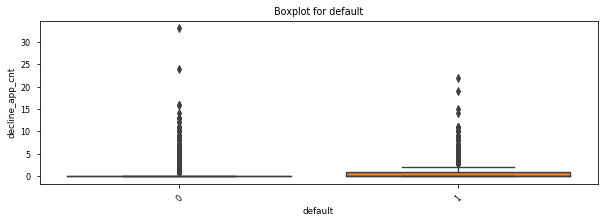

In [28]:
utils.get_boxplot(df_train, 'default', 'decline_app_cnt')

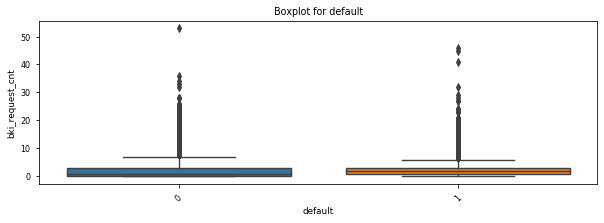

In [29]:
utils.get_boxplot(df_train, 'default', 'bki_request_cnt')

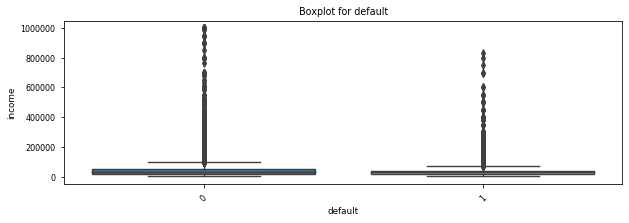

In [30]:
utils.get_boxplot(df_train, 'default', 'income')

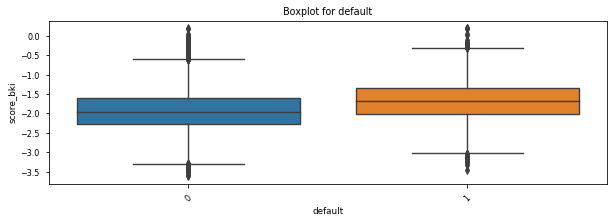

In [31]:
utils.get_boxplot(df_train, 'default', 'score_bki')

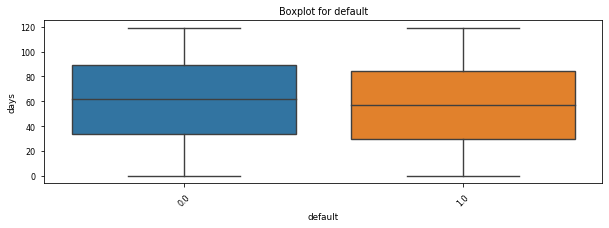

In [32]:
utils.get_boxplot(df[df['Train']==1], 'default', 'days')

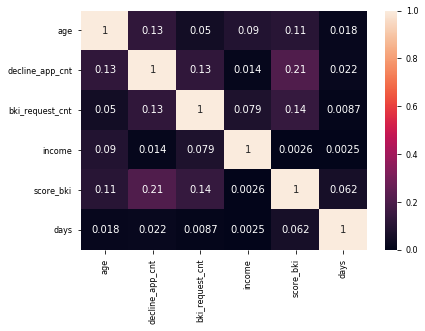

In [33]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Значимость непрерывных переменных

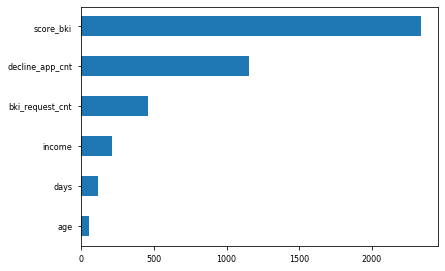

In [34]:
imp_num = Series(f_classif(df[df['Train'] == 1][num_cols], df[df['Train'] == 1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Бинарные переменные

8.-12. **sex, car, car_type, good_work, foreign_passport**

In [35]:
label_encoder = LabelEncoder()

mapped_sex = pd.Series(label_encoder.fit_transform(df['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [36]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [37]:
# Для бинарных признаков мы будем использовать LabelEncoder

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days
0,25905,2014-02-01,SCH,1,4.127134,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798127,4,1,0,0.0,1,31
1,63161,2014-03-12,SCH,0,4.077537,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852194,4,1,0,0.0,1,70
2,25887,2014-02-01,SCH,1,3.218876,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308953,1,4,1,0.0,1,31
3,16222,2014-01-23,SCH,0,3.970292,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210340,1,3,0,0.0,1,22
4,101655,2014-04-18,GRD,1,3.871201,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308953,1,4,1,0.0,1,107


### Категориальные переменные

In [38]:
cat_cols = ['education', 'home_address', 'work_address', 'region_rating', 'sna', 'first_time']

13. **education**

In [39]:
df.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

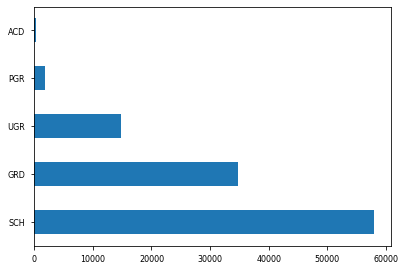

In [40]:
df.education.value_counts().plot.barh()

In [41]:
# Заполним пропуски Модой
df.loc[pd.isna(df.education), 'education'] = 'SCH'

In [42]:
# Преобразуем в числа
df.education = df.education.apply(lambda x: 0 if x=='SCH' else 1 if x=='GRD' else 2 if x=='UGR' else 3 if x=='PGR' else 4)

In [43]:
df.education.value_counts()

0    58476
1    34768
2    14748
3     1865
4      291
Name: education, dtype: int64

14. **home_address**

In [44]:
df.home_address.value_counts()

2    59591
1    48688
3     1869
Name: home_address, dtype: int64

15. **work_address**

In [45]:
df.work_address.value_counts()

3    67113
2    30761
1    12274
Name: work_address, dtype: int64

16. **region_rating**

In [46]:
df.region_rating.value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

Этот признак будем использовать как категориальный

17. **sna**

In [47]:
df.sna.value_counts()

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

18. **first_time**

In [48]:
df.first_time.value_counts()

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

Значимость категориальных и бинарных переменных

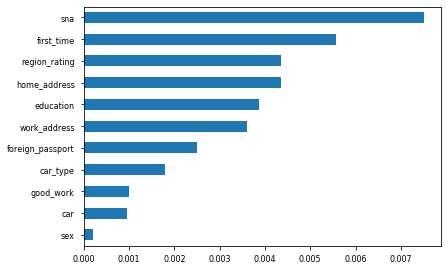

In [49]:
imp_cat = Series(mutual_info_classif(df[df['Train'] == 1][bin_cols + cat_cols], df[df['Train'] == 1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

## 3. Подготовка данных к использованию в моделе

In [50]:
# реализуем метод OneHotLabels через get_dummies
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [51]:
for i in num_cols:
    df[i] = StandardScaler().fit_transform(df[[i]])
    
# # стандартизацию проводим отдельно для трейна и теста, чтобы не допустить даталиков
# for i in num_cols:
#     df[df['Train']==1][i] = StandardScaler().fit_transform(df[[i]])
# for i in num_cols:
#     df[df['Train']==0][i] = StandardScaler().fit_transform(df[[i]])

In [52]:
#Удалим нечисловой признак
df.drop(['app_date'], axis=1, inplace=True)

In [53]:
df.head(3)

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,days,education_0,education_1,education_2,education_3,education_4,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,1,1.707409,1,1,-0.418815,0,-0.208688,-0.281790,-0.786072,0,0.0,1,-0.934391,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
1,63161,0,1.538018,0,0,-0.418815,0,0.745419,0.770563,-0.708463,0,0.0,1,0.281474,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
2,25887,1,-1.394610,1,0,2.621662,0,0.993988,-0.281790,-0.052822,1,0.0,1,-0.934391,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1


Подготовка признаков для модели завершена.

## 3. Построение модели

Разбиваем данные на тренировочные и тестовые

In [54]:
train_data = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

y = train_data.default.values            
X = train_data.drop(['default'], axis=1)

Проводим еще одно разбиение для возможности выбора и настройки модели

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [56]:
# проверим размерность данных
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 38), (73799, 38), (73799, 37), (59039, 37), (14760, 37))

Обучаем логистическую регрессию

In [57]:
model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

y_pred = model.predict(X_test)

## 4. Метрики качества

**ROC - кривая**

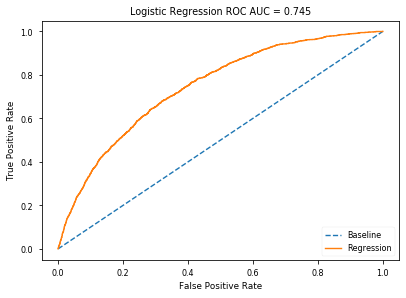

In [58]:
utils.display_roc_auc(y_test, probs)

**Матрица Ошибок (confusion_matrix)**

In [59]:
utils.print_confusion_matrix(y_test, y_pred)

Confusion matrix:
[[12872  1786]
 [   61    41]]
Размер тестовой выборки: 14760


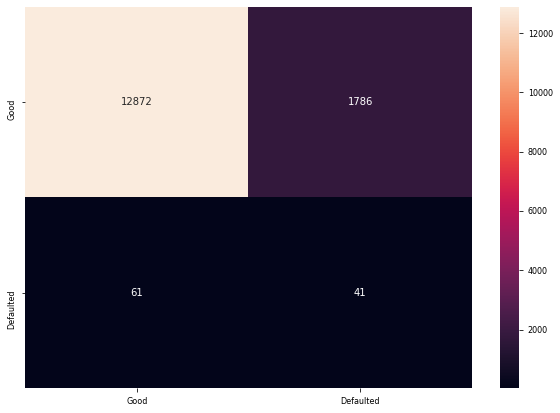

In [60]:
utils.display_confusion_matrix(y_test, y_pred)

**Метрики**

In [61]:
utils.print_classification_metrics(y_test, y_pred, probs)

,Значение,Описание
accuracy,0.874864,(TP+TN)/(P+N)
balanced accuracy,0.508862,сбалансированная accuracy
precision,0.401961,точность = TP/(TP+FP)
recall,0.022441,полнота = TP/P
f1_score,0.042509,среднее гармоническое точности и полноты
roc_auc,0.744691,Area Under Curve - Receiver Operating Characte...


**Резюме:** Судя по Матрице Ошибок и метрикам можно говорить о несостоятельности метрики ROC-AUC для данного примера. Вероятная причина заключается в несбалансированности данных. Модель плохо предсказывает дефолтных клиентов при высоком значении метрики ROC-AUC.

Посмотрим на метрику PRC-AUC и PRC - кривую.

**PRC-AUC и PRC - кривая**

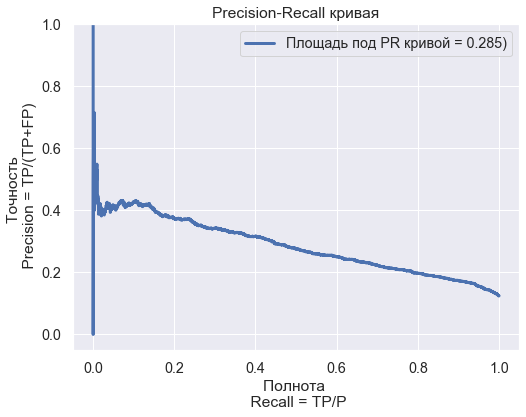

In [62]:
utils.display_PR_curve(y_test, probs, 1.3)

**Кросс - валидация**

In [63]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)

In [64]:
temp_vec

{'fit_time': array([0.14774895, 0.11944008, 0.14015555, 0.1132977 , 0.12263823,
        0.09517288, 0.12157369, 0.14211273, 0.11201739, 0.19946623]),
 'score_time': array([0.0019896 , 0.00099659, 0.00199413, 0.00103211, 0.00208974,
        0.00099826, 0.00261211, 0.00198889, 0.00199318, 0.00299048]),
 'test_score': array([0.75310817, 0.75635647, 0.72236612, 0.73258276, 0.73147972,
        0.71579628, 0.74313559, 0.74395125, 0.73948838, 0.76446101]),
 'train_score': array([0.74564815, 0.74504756, 0.74856638, 0.74797117, 0.74781435,
        0.74951244, 0.74658124, 0.74615529, 0.74712199, 0.74357206])}

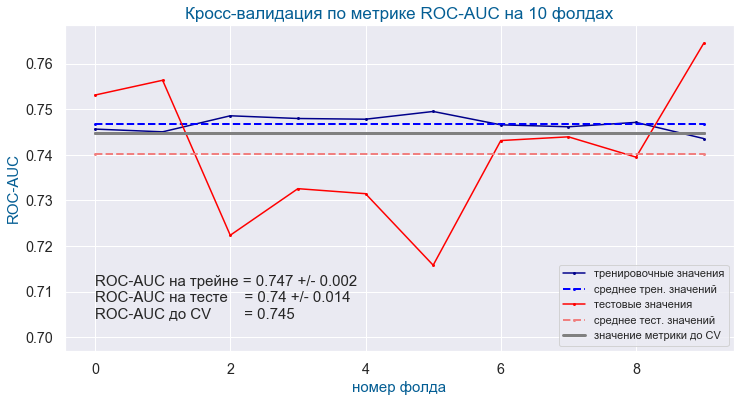

In [66]:
utils.cross_val_score_visualize('ROC-AUC', temp_vec, 0.744691, 1.3)